In [2]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from soilgasflux_fcs import json_reader, models, metrics
import xarray as xr
from scipy.stats import binned_statistic
import warnings
warnings.filterwarnings("ignore")

In [3]:
processed_data_path = pathlib.Path('/Users/alexnaokiasatokobayashi/Documents/FCS/processed_data/')
filename_regular = 'test05_2025-05-08.nc'
filename_mc = 'test05_MC_2025-05-08.nc'
filename_expected = 'expected_test05_2025-05-08.nc'

ds = xr.open_dataset(processed_data_path / filename_regular)
dsMC = xr.open_dataset(processed_data_path / filename_mc)
expected_ds = xr.open_dataset(processed_data_path / filename_expected)

In [4]:
test_a = expected_ds.isel(cutoff=0)['dcdt(HM)'].values
binned_statistic(test_a, test_a, bins=3)[2]
# Define your intensity categories
intensity_labels = ['low', 'medium', 'high']

# Calculate bin indices (0, 1, or 2)
bin_indices = binned_statistic(test_a, test_a, bins=3)[2] - 1  # -1 because bins are 1-indexed

# Map indices to labels
intensity_categories = np.array(intensity_labels)[bin_indices]
group_intensity = xr.DataArray(
    intensity_categories,
    coords={'time': expected_ds['time']},
    dims=['time']
)

expected_ds = expected_ds.assign_coords(intensity_categories=group_intensity)

In [5]:
def find_pareto_front(x, y, maximize_x=False, maximize_y=False):
    """
    Find the Pareto front for two objectives
    
    Parameters:
    -----------
    x, y : array-like
        Values of the two objectives
    maximize_x, maximize_y : bool
        Whether to maximize (True) or minimize (False) each objective
    
    Returns:
    --------
    pareto_indices : ndarray
        Indices of points on the Pareto front
    """
    import numpy as np
    
    # Copy arrays to avoid modifying originals
    x_values = np.copy(x)
    y_values = np.copy(y)
    
    # Convert maximization to minimization
    if maximize_x:
        x_values = -x_values
    if maximize_y:
        y_values = -y_values
    
    points = np.column_stack((x_values, y_values))
    pareto_indices = []
    
    for i, point in enumerate(points):
        if np.isnan(point).any():
            continue
            
        dominated = False
        for j, other_point in enumerate(points):
            if i != j and not np.isnan(other_point).any():
                # Check if other_point dominates point (smaller is better)
                if (all(other_point <= point) and any(other_point < point)):
                    dominated = True
                    break
        
        if not dominated:
            pareto_indices.append(i)
    
    return np.array(pareto_indices)


[0.]
0
(array([11]), array([0]))

[0.89846278 0.98659529 0.61542095 0.97818506]
2
(array([ 2,  9,  9, 11]), array([1, 0, 5, 0]))

[0.03307453 0.03324786 0.01901332 0.1024171  0.21921735]
2
(array([ 0,  1,  5,  8, 11]), array([0, 0, 0, 0, 0]))

[1.         0.9588591  0.55558042 0.32845729 0.85665622 0.34457959
 0.76138031 0.25472286 0.39148181 0.29534274]
7
(array([ 0,  1,  2,  3,  4,  4,  7,  8,  9, 10]), array([0, 0, 1, 2, 0, 2, 0, 4, 5, 3]))



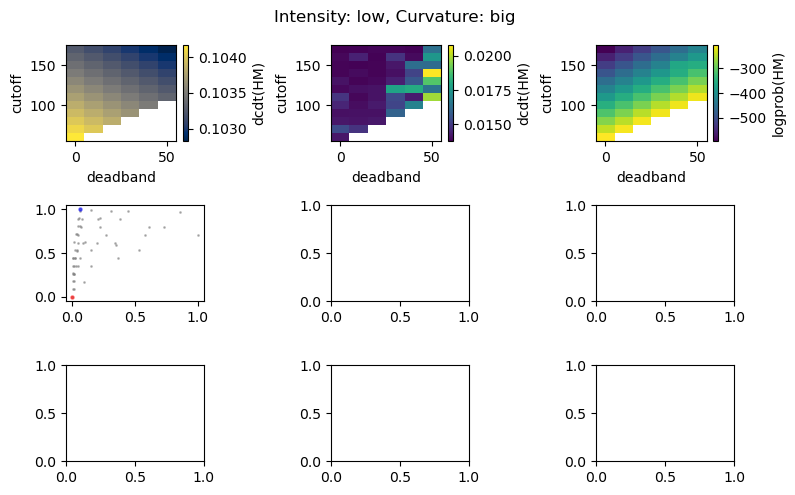

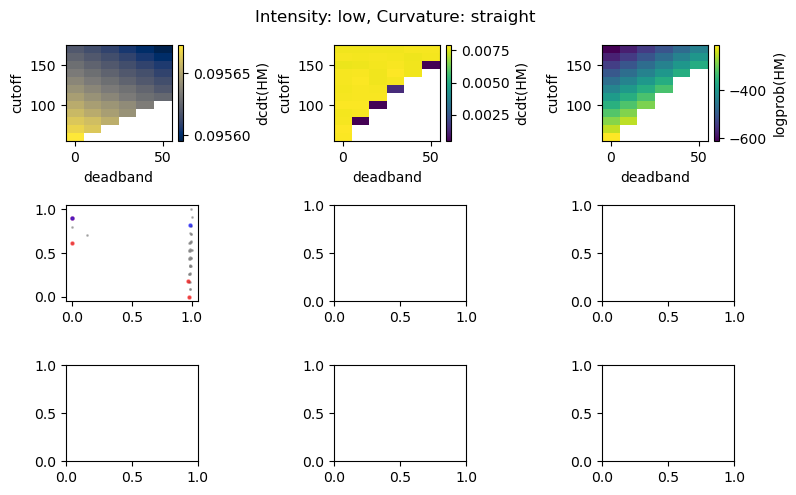

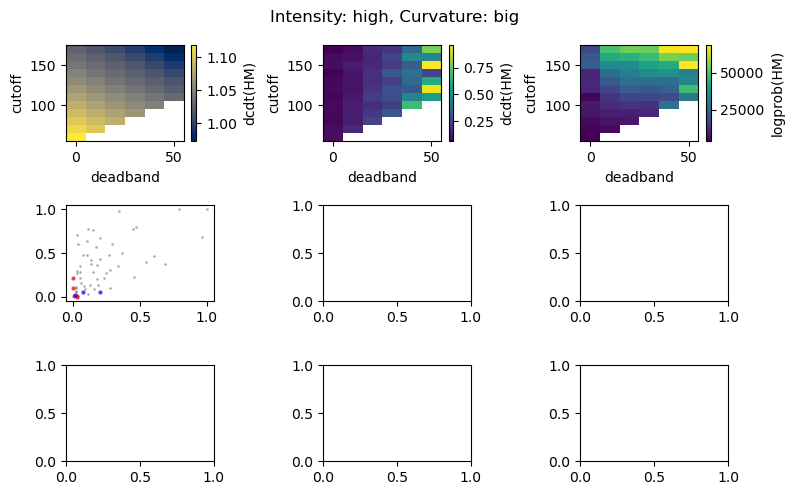

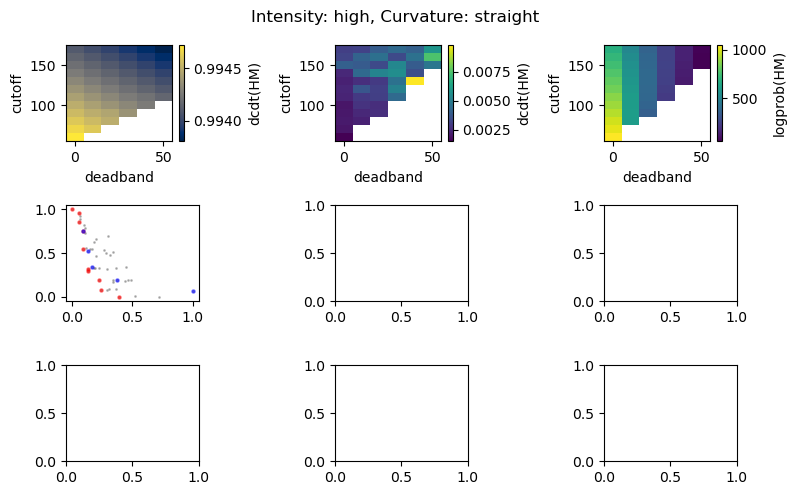

In [13]:
for intensity in ['low', 'high']:
    time_intensity = expected_ds.where(expected_ds['intensity_categories'] == intensity, drop=True)
    cutoff_coords, deadband_coords = ds.coords['cutoff'], ds.coords['deadband']

    for curve in np.unique(time_intensity['curvature'].values):
        time_selection = expected_ds.where((expected_ds['intensity_categories'] == intensity) & (expected_ds['curvature'] == curve), drop=True).time.values

        fig, ax = plt.subplots(3, 3, figsize=(8, 5))
        
        mc_hm = dsMC.sel(time=time_selection).median(dim=['MC','time'])['dcdt(HM)']
        uncertaintyRange_hm = dsMC.sel(time=time_selection).quantile(0.84, dim=['MC','time'])['dcdt(HM)']-dsMC.sel(time=time_selection).quantile(0.16, dim=['MC','time'])['dcdt(HM)']      
        logprob_hm = -dsMC.sel(time=time_selection).median(dim=['MC','time'])['logprob(HM)']

        Norm_uncertaintyRange = (uncertaintyRange_hm.values - np.nanmin(uncertaintyRange_hm)) / (np.nanmax(uncertaintyRange_hm) - np.nanmin(uncertaintyRange_hm))
        Norm_logprob = (logprob_hm.values - np.nanmin(logprob_hm)) / (np.nanmax(logprob_hm) - np.nanmin(logprob_hm))
        
        flatNorm_uncertaintyRange = (uncertaintyRange_hm.values.flatten() - np.nanmin(uncertaintyRange_hm)) / (np.nanmax(uncertaintyRange_hm) - np.nanmin(uncertaintyRange_hm))
        flatNorm_logprob = (logprob_hm.values.flatten() - np.nanmin(logprob_hm)) / (np.nanmax(logprob_hm) - np.nanmin(logprob_hm))

        # Find Pareto front
        pareto_uncertaintyRange_logprob = find_pareto_front(x=flatNorm_uncertaintyRange, 
                                                            y=flatNorm_logprob, 
                                                            maximize_x=False, maximize_y=False)
        coords_pareto_uncertaintyRange_logprob = np.unravel_index(pareto_uncertaintyRange_logprob, uncertaintyRange_hm.shape)
        distance_pareto_uncertaintyRange_logprob = np.sqrt((Norm_uncertaintyRange[coords_pareto_uncertaintyRange_logprob])**2 + 
                                                           (Norm_logprob[coords_pareto_uncertaintyRange_logprob])**2)
        # argmin_distance_pareto_uncertaintyRange_logprob = np.unravel_index(np.argmin(distance_pareto_uncertaintyRange_logprob), uncertaintyRange_hm.shape)
        argmin_distance_pareto_uncertaintyRange_logprob = np.nanargmin(distance_pareto_uncertaintyRange_logprob)
        



        ax[1,0].scatter(flatNorm_uncertaintyRange, flatNorm_logprob, s=1, c='gray', alpha=0.5)
        ax[1,0].scatter(Norm_uncertaintyRange[coords_pareto_uncertaintyRange_logprob], 
                        Norm_logprob[coords_pareto_uncertaintyRange_logprob], 
                        s=5, c='red', alpha=0.5)
        ax[1,0].scatter(Norm_uncertaintyRange[argmin_distance_pareto_uncertaintyRange_logprob],
                        Norm_logprob[argmin_distance_pareto_uncertaintyRange_logprob], 
                        s=5, c='blue', alpha=0.5)
        print(distance_pareto_uncertaintyRange_logprob)
        print(argmin_distance_pareto_uncertaintyRange_logprob)

        print(coords_pareto_uncertaintyRange_logprob)
        print()
        # print(argmin_distance_pareto_uncertaintyRange_logprob)
        # print(coords_pareto_uncertaintyRange_logprob)
        # print(argmin_distance_pareto_uncertaintyRange_logprob)
        # print(flatNorm_uncertaintyRange[argmin_distance_pareto_uncertaintyRange_logprob[0]])
        # print(flatNorm_logprob[argmin_distance_pareto_uncertaintyRange_logprob[1]])
        # ax[1,0].plot([0, flatNorm_uncertaintyRange[argmin_distance_pareto_uncertaintyRange_logprob[0]]],
        #             [0, flatNorm_logprob[argmin_distance_pareto_uncertaintyRange_logprob[1]]], 
        #             color='black', linestyle='--')
        # ax[1,0].plot([0,1], [0,1], color='black', linestyle='--')


        #### Plots ####
        ds.sel(time=time_selection)['dcdt(HM)'].median(dim='time').plot(ax=ax[0, 0], cmap='cividis')
        uncertaintyRange_hm.plot(ax=ax[0, 1], cmap='viridis')
        logprob_hm.plot(ax=ax[0, 2], cmap='viridis')

        fig.suptitle(f'Intensity: {intensity}, Curvature: {curve}')
        fig.tight_layout()
        fig.show()
        # break